In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV,learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
import joblib

from EDA import analyse_exploratoire,graphique,clean_data,nuage_mots

In [ ]:
# Téléchargement des ressources NLTK et initialisation des outils de traitement
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [ ]:
# Téléchargement de la base de donnée
data=pd.read_csv(r"../data/dataSet_Emails.csv",index_col=0)
data.head()

,message_id,text,label,label_text,subject,message,date
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


In [5]:
# Afficher l'analyse exploratoire
analyse_exploratoire(data)

notre data contient 31716 lignes et 7 colonnes

Data info :
<class 'pandas.core.frame.DataFrame'>
Index: 31716 entries, 0 to 31715
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message_id  31716 non-null  int64 
 1   text        31665 non-null  object
 2   label       31716 non-null  int64 
 3   label_text  31716 non-null  object
 4   subject     31442 non-null  object
 5   message     31371 non-null  object
 6   date        31716 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.9+ MB
None

Statistiques:
         message_id         label
count  31716.000000  31716.000000
mean   16854.187539      0.509617
std     9734.616392      0.499915
min        0.000000      0.000000
25%     8429.750000      0.000000
50%    16850.500000      1.000000
75%    25295.250000      1.000000
max    33715.000000      1.000000

Le nombres de données manquantes par colonnes:
message_id      0
text           51
label           0

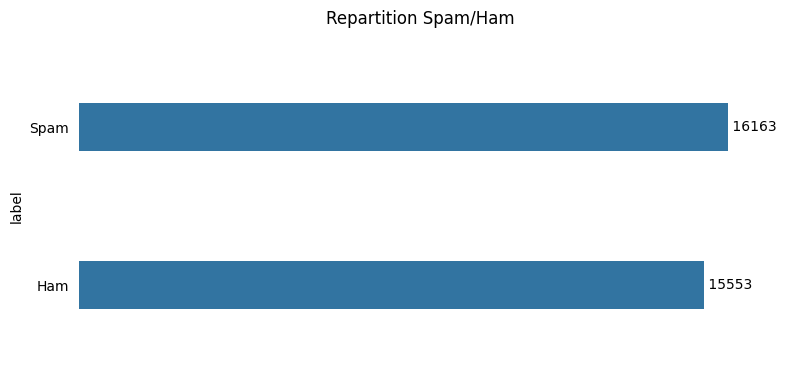

In [6]:
#Afficher les graphiques
graphique(data,'label')

In [18]:
# Nettoyer la data
data=clean_data(data)
print(f"notre data contient {data.shape[0]} lignes et {data.shape[1]} colonnes")

notre data contient 31665 lignes et 7 colonnes


In [ ]:
#Fonction de preprocessing
def preprocess_text_func(text):
    text_1=str(text)
    text_1=text_1.lower()

    # Tokenisation (décompose le texte en tokens)
    tokens = word_tokenize(text_1)
    
    # Supprimer la ponctuation et les caractères spéciaux
    tokens = [re.sub(f'[{re.escape(string.punctuation)}]', '', token) for token in tokens]
    tokens = [token for token in tokens if token]  # supprimer les tokens vides après suppression ponctuation

    if stop_words is None:
        raise ValueError
    
    # Supprimer les stop_words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Appliquer le stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    #Join tolkens
    processed_text_str = ' '.join(stemmed_tokens)
    
    return processed_text_str

### 🔎 `Tokenisation`
Tokenisation

Décompose le texte en mots individuels (tokens)
"Hello world!" → ["Hello", "world", "!"]
Facilite l'analyse mot par mot

---

### 🔎 `Stemming`

Réduit les mots à leur racine commune
"running", "runs", "ran" → "run"
Évite de traiter les variantes comme des mots différents

### 🔎 `TFIDF`

TF-IDF mesure l'importance d'un mot dans un document par rapport à une collection de documents.

In [20]:
data['text_preprocessed']=data['text'].apply(preprocess_text_func)
data.head()

,message_id,text,label,label_text,subject,message,date,text_preprocessed
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18,softwar 15 99 understand oem softwar lead temp...
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19,perspect ferc regulatori action client conf ca...
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11,want tri ci 4 li thought way expens viagra 1 1...
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12,enron hpl actual decemb 11 2000 teco tap 30 00...
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13,look cheap high qualiti softwar rotat napoleon...


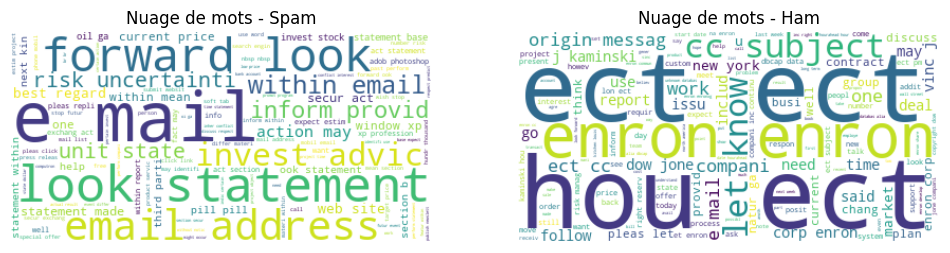

In [21]:
# Afficher les nuages de mots
nuage_mots(data,'text_preprocessed')

Modèles

In [22]:
#Separation en train et test

X = data['text_preprocessed']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [ ]:
#Définition des pipelines et et des paramètres
pipelines_and_params = {
    "Decision Tree": (
        Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=None, max_features=5000, ngram_range=(1,2), min_df=2, max_df=0.95)),
            ('clf', DecisionTreeClassifier(random_state=42))
        ]),
        {
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2]
        }
    ),
    "Multinomial": (
        Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=None, max_features=5000, ngram_range=(1,2), min_df=2, max_df=0.95)),
            ('clf', MultinomialNB())
        ]),
        {
            'clf__alpha': [0.5, 1.0, 1.5]
        }
    ),
    "Linear SVC": (
        Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=None, max_features=5000, ngram_range=(1,2), min_df=2, max_df=0.95)),
            ('clf', CalibratedClassifierCV(estimator=LinearSVC(random_state=42, max_iter=5000), method='sigmoid', cv=5))
        ]),
        {
            'clf__estimator__C': [0.1, 1, 10]
        }
    )
}

In [ ]:
#Recherche et enregistrement des modèles

models_best_estimators = {}
results_summary = []

n_iter_search = 12

for name, (pipe, param_grid) in pipelines_and_params.items():
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=n_iter_search,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1,
        verbose=0,
        refit=True,
        random_state=42,
    )
    
    search.fit(X_train, y_train)
    best_estimator = search.best_estimator_

    modele_key = f"Modele_{name.replace(' ', '_')}"
    models_best_estimators[modele_key] = best_estimator

    y_pred = best_estimator.predict(X_test)
    best_test_f1 = classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]

    results_summary.append({
        "Modèle": name,
        "CV F1 (moyenne)": search.best_score_,
        "CV F1 (écart-type)": search.cv_results_["std_test_score"][search.best_index_],
        "F1 test": best_test_f1
    })

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=12. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=12. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [25]:
df_results = pd.DataFrame(results_summary)
print(df_results)

          Modèle  CV F1 (moyenne)  CV F1 (écart-type)   F1 test
0  Decision Tree         0.953933            0.002731  0.957183
1    Multinomial         0.980711            0.001150  0.980924
2     Linear SVC         0.987746            0.001084  0.988126


✅ Le modèle SVC est le plus performant sur le jeu test donc c'est celui que l'on selectionne.

In [ ]:
#Affichage des modèles obtenus
for model, valeur in models_best_estimators.items():
    print(model, valeur)
    print()

Modele_Decision_Tree Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf', DecisionTreeClassifier(random_state=42))])

Modele_Multinomial Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.5))])

Modele_Linear_SVC Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf',
                 CalibratedClassifierCV(cv=5,
                                        estimator=LinearSVC(C=1, max_iter=5000,
                                                            random_state=42)))])



In [ ]:
#Affichage des metrics pour tous les modèles
for modele_name, pipeline in models_best_estimators.items():
    print(f"\n=== {modele_name} ===")
    y_pred = pipeline.predict(X_test)
    y_pred_train= pipeline.predict(X_train)
    cm = confusion_matrix(y_test, y_pred)
    cm_train = confusion_matrix(y_train,y_pred_train)
    print("Matrice de confusion train :\n", cm_train)
    print("Rapport de classification train :")
    print(classification_report(y_train, y_pred_train, digits=3))
    print("Matrice de confusion test :\n", cm)
    print("Rapport de classification test :")
    print(classification_report(y_test, y_pred, digits=3))


=== Modele_Decision_Tree ===
Matrice de confusion train :
 [[11660     4]
 [    0 12084]]
Rapport de classification train :
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     11664
           1      1.000     1.000     1.000     12084

    accuracy                          1.000     23748
   macro avg      1.000     1.000     1.000     23748
weighted avg      1.000     1.000     1.000     23748

Matrice de confusion test :
 [[3731  158]
 [ 181 3847]]
Rapport de classification test :
              precision    recall  f1-score   support

           0      0.954     0.959     0.957      3889
           1      0.961     0.955     0.958      4028

    accuracy                          0.957      7917
   macro avg      0.957     0.957     0.957      7917
weighted avg      0.957     0.957     0.957      7917


=== Modele_Multinomial ===
Matrice de confusion train :
 [[11372   292]
 [  135 11949]]
Rapport de classification train :
         

✅ Le modèle SVC retenus obtiens un F1 score de 0.998 sur le train et 0.988 sur le test.

In [28]:
model = models_best_estimators.get("Modele_Linear_SVC")

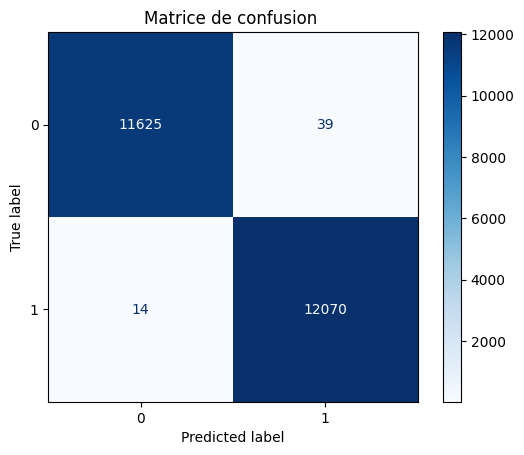

In [ ]:
y_pred = model.predict(X_test)
y_pred_train= model.predict(X_train)
cm = confusion_matrix(y_test, y_pred)
cm_train = confusion_matrix(y_train,y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp.plot(cmap='Blues') 
plt.title ("Matrice de confusion ")
plt.savefig('..\\plots\\Matrice_de_confusion.png')
plt.show()

✅ La matrice de confusion nous infdique que 14 messages ham ont été classifiés comme spam par le modèle (FP).

✅  39 messages spam ont été classifié comme ham (FN).

✅ Globalement les résultats obtenus sont très satisfaisant.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


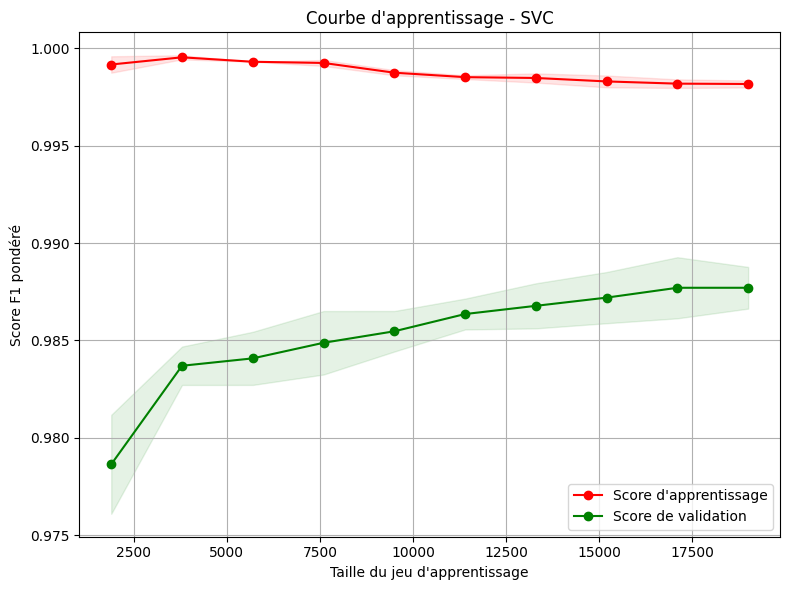

In [ ]:
# Affichage de la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X= X_train,
    y= y_train,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Score d'apprentissage")
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Score de validation")
plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='g')
plt.xlabel("Taille du jeu d'apprentissage")
plt.ylabel("Score F1 pondéré")
plt.title("Courbe d'apprentissage - SVC")
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.savefig('..\\plots\\Courbe_apprentissage_SVC.png')
plt.show()

✅ Excellent modèle : Scores F1 très élevés

✅ Pas de surapprentissage : Les courbes convergent au lieu de diverger

✅ Bonne généralisation : Score de validation s'améliore et se stabilise

✅ Données suffisantes : Performance stable après 12k échantillons

Conclusion : Modèle SVC optimal pour détecter le spam.

In [ ]:
joblib.dump(model,r"../model/model.pkl")

['model.pkl']